# Comparison of Dirichlet wrapper with Kendall aleatoric uncertainty model
The goal of this work is to compare the aleatoric uncertainty obtained by means of the Dirichlet wrapper proposed and Kendall's.

In [1]:
import pandas as pd
import numpy as np
'''NN'''
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Input, concatenate, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_probability as tfp

## Toy dataset
This section holds a preliminar version of the ensemble based on a syntethic dataset generated automaticaly.

In [2]:
#@title Toy dataset generator Params
num_centers = 3 #@param {type:"slider", min:2, max:10, step:1}
n_samples = 20000 #@param {type:"integer"}
n_features = 2 #@param {type:"integer"}
cluster_std = 3 #@param {type:"slider", min:0, max:4, step:0.1}
num_classes = 3 #@param {type:"slider", min:2, max:10, step:1}
num_mc_samples = 1000 #@param {type:"integer"}

### Generate the data points

In [5]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.tri as tri

from pandas import DataFrame
# generate 2d classification dataset
X, y = make_blobs(n_samples=n_samples, centers=num_centers, n_features=n_features, cluster_std=cluster_std, random_state=6)
#fake_data = np.random.normal((5,-25), 1, [1000,num_classes])
#X = np.concatenate((X,fake_data))
#y = np.concatenate((y,np.array([0]*fake_data.shape[0])))

### Split the data on training and testing

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)
fake_data_test = np.random.normal((20,-20), 1, [1000,n_features])
X_test = np.concatenate((X_test,fake_data_test))
y_test = np.concatenate((y_test,np.array([2]*fake_data_test.shape[0])))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, 
                                                    random_state=42)
fake_data_val = np.random.normal((20,-20), 1, [1000,n_features])
X_val = np.concatenate((X_val,fake_data_val))
y_val = np.concatenate((y_val,np.array([2]*fake_data_val.shape[0])))

### Visualize the points

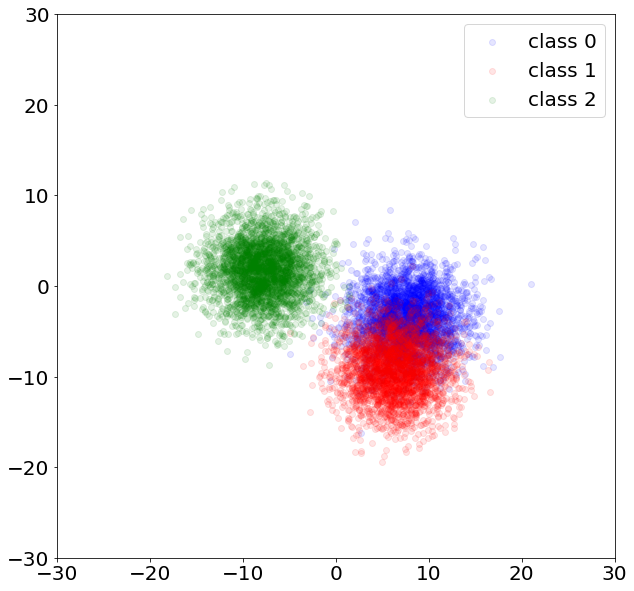

In [7]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,10))
plt.gca().set_xlim([-30.,30.])
plt.gca().set_ylim([-30.,30.])
plt.scatter(X_train[:,0][y_train==0], X_train[:,1][y_train==0], label='class 0', c='b',  alpha=0.1)
plt.scatter(X_train[:,0][y_train==1], X_train[:,1][y_train==1], label='class 1', c='r',  alpha=0.1)
plt.scatter(X_train[:,0][y_train==2], X_train[:,1][y_train==2], label='class 2', c='g',  alpha=0.1)
plt.legend()

## Fake classifier
We then train a classifier on the fake data to obtain the corresponding logits.

In [8]:
fake_input = Input(shape=(n_features,))
fake_output = Dense(num_classes, activation='softmax')(fake_input)
fake_model = Model(inputs=[fake_input], outputs=fake_output)
fake_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(lr=1e-3),
                  metrics=['accuracy'])
fake_es = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', restore_best_weights=True)
fake_training_history = fake_model.fit([X_train],
                                 y_train,
                                 batch_size=64,
                                 epochs=100,
                                 verbose=1,
                                 callbacks=[fake_es],
                                 validation_split=0.1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 8640 samples, validate on 960 samples
Epoch 1/100
8640/8640 [==============================] - 0s 18us/sample - loss: 4.5278 - acc: 0.2652 - val_loss: 3.5332 - val_acc: 0.3104
Epoch 2/100
8640/8640 [==============================] - 0s 11us/sample - loss: 2.8843 - acc: 0.3341 - val_loss: 2.2237 - val_acc: 0.3854
Epoch 3/100
8640/8640 [==============================] - 0s 11us/sample - loss: 1.8250 - acc: 0.4381 - val_loss: 1.4341 - val_acc: 0.5771
Epoch 4/100
8640/8640 [==============================] - 0s 12us/sample - loss: 1.2016 - acc: 0.6321 - val_loss: 0.9807 - val_acc: 0.6844
Epoch 5/100
8640/8640 [==============================] - 0s 11us/sample - loss: 0.8427 - acc: 0.7273 - val_loss: 0.7191 - val_acc: 0.7417
Epoch 6/100
8640/8640 [==============================] - 0s 11us/sample - loss: 0.6364 - acc: 0.7738 - val_loss: 0.5680 - val_acc: 0.7729
Epoch 7/100
8640/8640 [=====================

Epoch 57/100
8640/8640 [==============================] - 0s 10us/sample - loss: 0.2498 - acc: 0.8888 - val_loss: 0.2897 - val_acc: 0.8646
Epoch 58/100
8640/8640 [==============================] - 0s 10us/sample - loss: 0.2497 - acc: 0.8882 - val_loss: 0.2902 - val_acc: 0.8635
Epoch 59/100
8640/8640 [==============================] - 0s 10us/sample - loss: 0.2495 - acc: 0.8889 - val_loss: 0.2891 - val_acc: 0.8667
Epoch 60/100
8640/8640 [==============================] - 0s 11us/sample - loss: 0.2489 - acc: 0.8897 - val_loss: 0.2892 - val_acc: 0.8646
Epoch 61/100
8640/8640 [==============================] - 0s 10us/sample - loss: 0.2489 - acc: 0.8904 - val_loss: 0.2886 - val_acc: 0.8687
Epoch 62/100
8640/8640 [==============================] - 0s 10us/sample - loss: 0.2488 - acc: 0.8912 - val_loss: 0.2891 - val_acc: 0.8667
Epoch 63/100
8640/8640 [==============================] - 0s 10us/sample - loss: 0.2482 - acc: 0.8904 - val_loss: 0.2888 - val_acc: 0.8677
Epoch 64/100
8640/8640 [===

### Visualize the classification

In [9]:
fake_y_pred_train = fake_model.predict([X_train])
fake_y_pred_val = fake_model.predict([X_val])
fake_y_pred_test = fake_model.predict([X_test])

We evaluate the mean of the accuracy for train and test

In [10]:
np.mean(fake_y_pred_train.argmax(axis=1)==y_train), np.mean(fake_y_pred_test.argmax(axis=1)==y_test)

(0.8886458333333334, 0.717)

We plot now the result of the classification for test

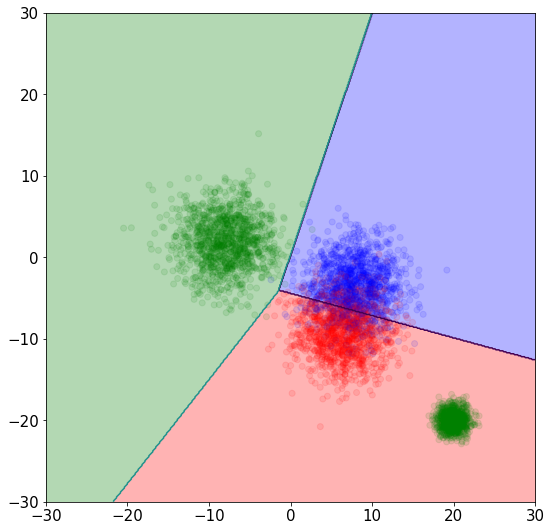

In [11]:
def plot_classifier(model, X, y, point = None):
    plt.figure(figsize=(10,10))
    plt.rcParams.update({'font.size': 15})
    N_points = 500
    xx,yy = np.meshgrid(np.linspace(-30,30,N_points),np.linspace(-30,30,N_points))
    viz=np.c_[xx.ravel(),yy.ravel()]
    z = np.argmax(model.predict(viz),axis=1)

    prd_colors = {
        0: 'b',
        1: 'r',
        2: 'g'
    }

    prd_color = [prd_colors[i] for i in y]
    cmap = mpl.colors.ListedColormap(prd_colors.values())

    plt.scatter(X[:, 0], X[:, 1], c=prd_color,  alpha=0.1)
    plt.gca().set_xlim([-30.,30.])
    plt.gca().set_ylim([-30.,30.])
    plt.imshow(z.reshape((N_points,N_points)), interpolation='bilinear', origin='lower', extent=(-30,30,-30,30),alpha=0.3, vmin=0, vmax=2, cmap=cmap)
    plt.contour(xx,yy,z.reshape((N_points,N_points)),[0,1,2])
    if point is not None:
      plt.plot(point[0], point[1], 'y*', markersize=30)
    plt.gcf().set_size_inches((9,9))

    plt.show()

plot_classifier(fake_model, X_test, y_test)

## Uncertainty: Softmax Response

In [12]:
uncertainty_softmax_response = 1 - np.max(fake_y_pred_test, axis=1)

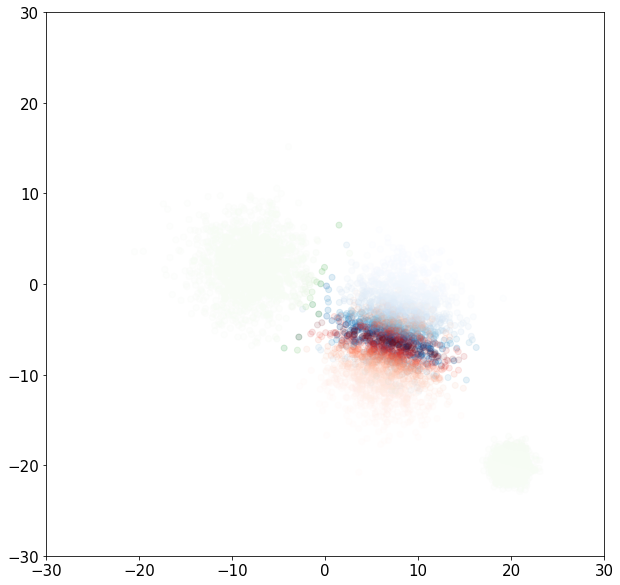

In [13]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,10))
plt.gca().set_xlim([-30.,30.])
plt.gca().set_ylim([-30.,30.])
color = uncertainty_softmax_response[y_test==0]
pa = plt.scatter(X_test[:,0][y_test==0],
         X_test[:,1][y_test==0], 
                 c=color, cmap='Blues', alpha=0.2)
#cba = plt.colorbar(pa)
color = uncertainty_softmax_response[y_test==1]
pb = plt.scatter(X_test[:,0][y_test==1],
         X_test[:,1][y_test==1], 
                 c=color, cmap='Reds', alpha=0.1)
#cbb = plt.colorbar(pb)
color = uncertainty_softmax_response[y_test==2]
pc = plt.scatter(X_test[:,0][y_test==2],
         X_test[:,1][y_test==2], 
                 c=color, cmap='Greens', alpha=0.2)
#cbc = plt.colorbar(pc)
#cba.set_label('zero')
#cbb.set_label('one')
#cbc.set_label('two')

## Uncertainty: Kendall's aleatoric

First we need to obtain the logits from the original model

In [14]:
mu_weights = fake_model.get_weights()
logits_model_input = Input(shape=(n_features,))
logits    = Dense(num_classes, activation=None, trainable = False, weights=mu_weights)(logits_model_input)

logits_model = Model(inputs=[logits_model_input], outputs=logits)
train_logits = logits_model.predict(X_train)
val_logits = logits_model.predict(X_val)
test_logits = logits_model.predict(X_test)

Definition of the kendall's aleatoric wrapper

In [16]:
def max_sigma(y_true, y_pred):
    logits_psi = y_pred[:, num_classes:]

    return tf.reduce_max(logits_psi)

def mu_accuracy(y_true, y_pred):
    logits_phi = y_pred[:, :num_classes]
    labels_phi = y_true[:, :num_classes]
    return categorical_accuracy(labels_phi, logits_phi)

def softmax_cross_entropy(y_true, y_pred):
    lambda_reg = 0
    y_true = y_true[:, :num_classes]
    y_true_expanded = tf.expand_dims(y_true,axis=0)
    y_true_expanded = tf.tile(y_true_expanded, [num_mc_samples, 1, 1])
    logits_mu = tf.expand_dims(y_pred[:, :num_classes],axis=0)
    logits_sigma = tf.expand_dims(y_pred[:, num_classes:],axis=0)

    noise = tf.random_normal((lambda shape: (num_mc_samples , shape[1], shape[2]))(tf.shape(logits_sigma)))
    z = tf.tile(logits_mu, [num_mc_samples, 1, 1]) + noise * tf.tile(logits_sigma, [num_mc_samples, 1, 1])
    z_probs = tf.nn.softmax(z, axis=-1)
    e_probs = tf.reduce_mean(z_probs, axis=0)
    log_probs = tf.log(e_probs)
    cross_entropy = -(tf.reduce_sum(y_true * log_probs, axis=-1))
    return cross_entropy #+ lambda_reg * tf.reduce_sum(tf.square(logits_sigma), axis=-1)

def kendalls_model():
  
    logits = Input(shape=(num_classes,))
    data_input = Input(shape=(n_features,))

    bn = False
    dp = False

    sigma = data_input
    if dp:
        sigma = Dropout(rate=do_rate)(sigma)
    sigma = Dense(20, activation=None)(sigma)
    if bn:
        sigma = BatchNormalization()(sigma)
    sigma = Activation('relu')(sigma)
    if dp:
        sigma = Dropout(rate=do_rate)(sigma)
    sigma = Dense(20,activation=None)(sigma)
    if bn:
        sigma = BatchNormalization()(sigma)
    sigma = Activation('relu')(sigma)
    if dp:
        sigma = Dropout(rate=do_rate)(sigma)
    sigma = Dense(20,activation=None)(sigma)
    if bn:
        sigma = BatchNormalization()(sigma)
    sigma = Activation('relu')(sigma)
    if dp:
        sigma = Dropout(rate=do_rate)(sigma)
    sigma = Dense(num_classes, activation=None)(sigma)
    if bn:
        print("batch_norm")
        sigma = BatchNormalization()(sigma)
    #sigma = Activation((lambda x: K.softplus(x + 5.)))(sigma)
    sigma = Activation('softplus')(sigma)
    if dp:
        print("dropout")
        sigma = Dropout(rate=do_rate)(sigma)
    output = concatenate([logits, sigma])
    model = Model(inputs=[logits, data_input], outputs=output)
    model.compile(loss=softmax_cross_entropy,
                optimizer=Adam(lr=0.001),
                metrics=[mu_accuracy, max_sigma])
    return model
  

In [17]:
kendalls_model_impl = kendalls_model()
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='auto', restore_best_weights=True)
training_history = kendalls_model_impl.fit([val_logits, X_val],
                             np.tile(to_categorical(y_val, num_classes), [1, 2]),
                             batch_size=256,
                             epochs=10,
                             verbose=1,
                             callbacks=[es],
                             validation_split=0.1)

Train on 6660 samples, validate on 740 samples
Epoch 1/10
6660/6660 [==============================] - 0s 67us/sample - loss: 2.1452 - mu_accuracy: 0.8628 - max_sigma: 6.3610 - val_loss: 47.7802 - val_mu_accuracy: 0.0000e+00 - val_max_sigma: 8.8269
Epoch 2/10
6660/6660 [==============================] - 0s 47us/sample - loss: 2.1281 - mu_accuracy: 0.8628 - max_sigma: 8.1026 - val_loss: 47.8242 - val_mu_accuracy: 0.0000e+00 - val_max_sigma: 8.6872
Epoch 3/10
6660/6660 [==============================] - 0s 47us/sample - loss: 2.1198 - mu_accuracy: 0.8628 - max_sigma: 7.9496 - val_loss: 47.8478 - val_mu_accuracy: 0.0000e+00 - val_max_sigma: 8.3505
Epoch 4/10
6660/6660 [==============================] - 0s 50us/sample - loss: 2.1135 - mu_accuracy: 0.8628 - max_sigma: 8.3786 - val_loss: 47.7544 - val_mu_accuracy: 0.0000e+00 - val_max_sigma: 9.2628
Epoch 5/10
6660/6660 [==============================] - 0s 47us/sample - loss: 2.1090 - mu_accuracy: 0.8628 - max_sigma: 9.1741 - val_loss: 47.66

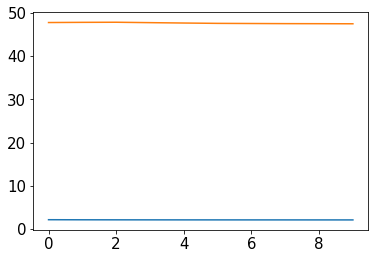

In [18]:
plt.plot(training_history.history['loss'])
plt.plot(training_history.history['val_loss'])

In [19]:
kendalls_preds = kendalls_model_impl.predict([test_logits, X_test])

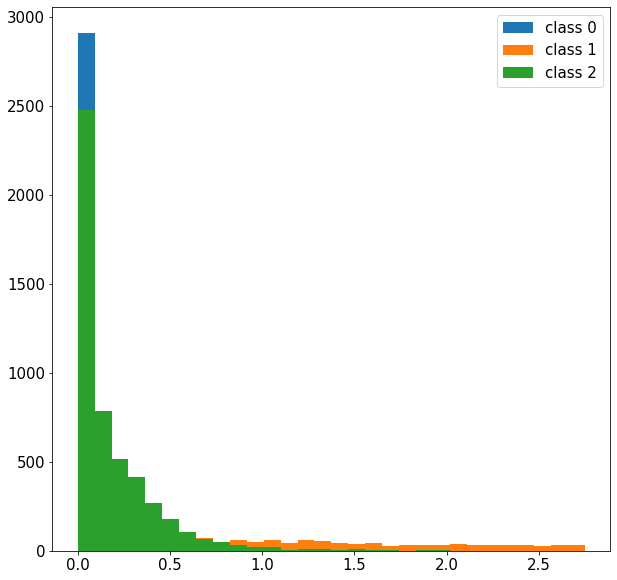

In [20]:
plt.figure(figsize=(10,10))
#_, bins, _ = plt.hist(kendalls_preds[:,3], bins=30, label='class 2')
_, bins = np.histogram(kendalls_preds[:,5], bins=30)
plt.hist(kendalls_preds[:,3], bins=bins, label='class 0')
plt.hist(kendalls_preds[:,4], bins=bins, label='class 1')
plt.hist(kendalls_preds[:,5], bins=bins, label='class 2')
plt.legend()


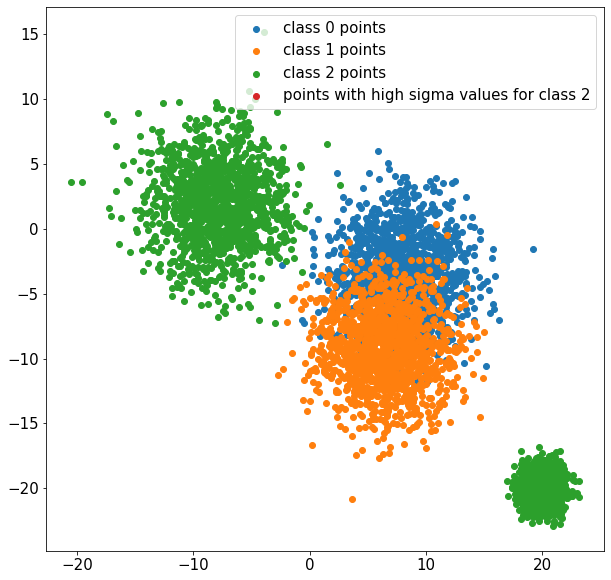

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(X_test[:,0][y_test==0], X_test[:,1][y_test==0], label='class 0 points')
plt.scatter(X_test[:,0][y_test==1], X_test[:,1][y_test==1], label='class 1 points')
plt.scatter(X_test[:,0][y_test==2], X_test[:,1][y_test==2], label='class 2 points')
plt.scatter(X_test[:,0][np.where(kendalls_preds[:,5] > 20)], X_test[:,1][np.where(kendalls_preds[:,5] > 20)], label='points with high sigma values for class 2')
plt.legend()

In [22]:
from  scipy.special import softmax
kendalls_preds[4001], softmax(kendalls_preds[4001][0:3]), softmax(np.array([ 4.1747417e+00,  1.1261232e+01, 160.0465370e+01]))

(array([ 5.9906282e+00,  1.3026499e+01, -4.1335205e+01,  7.0054870e-07,
         1.1312827e+01,  1.0747761e-02], dtype=float32),
 array([8.7897875e-04, 9.9912113e-01, 2.4582728e-24], dtype=float32),
 array([0., 0., 1.]))

In [23]:
kendalls_preds[3895], softmax(kendalls_preds[3895][0:3]), softmax(np.array([ 0.42826974, -0.2643671 , -12.0354798]))

(array([ 6.3700211e-01,  3.9565563e-04, -3.4814882e-01,  2.2721991e-01,
         6.9790274e-02,  2.4419703e-01], dtype=float32),
 array([0.52563304, 0.2781045 , 0.19626239], dtype=float32),
 array([6.66551531e-01, 3.33445893e-01, 2.57570476e-06]))

In [24]:
from scipy.special import softmax
def predict_kendalls_entropy(y_pred):
    epsilon = 10e-10
    logits_mu = y_pred[:,:num_classes]
    logits_sigma = y_pred[:,num_classes:]

    noise = np.random.normal(loc=0, scale=1, size=(lambda shape: (num_mc_samples*shape[0], shape[1]))(np.shape(logits_sigma)))
    z = np.tile(logits_mu, [num_mc_samples,1]) + noise * np.tile(logits_sigma, [num_mc_samples, 1])
    sample_probs = softmax(z, axis=-1)
    log_sample_probs = np.log(sample_probs + epsilon)
    sample_information = np.sum(-sample_probs*log_sample_probs, axis=-1)
    entropy = np.mean(np.reshape(sample_information,(lambda shape: (num_mc_samples,shape[0]))(np.shape(logits_sigma)))
                            , axis=0)
    return entropy

def predict_voting(y_pred):
    epsilon = 10e-10
    logits_mu = y_pred[:,:num_classes]
    logits_sigma = y_pred[:,num_classes:]
    
    noise = tf.random_normal((lambda shape: (num_mc_samples*shape[0], shape[1]))(tf.shape(logits_sigma)))
    z = tf.tile(logits_mu, [num_mc_samples,1]) + noise * tf.tile(logits_sigma, [num_mc_samples, 1])
    sampled_output = tf.argmax(z, axis=-1, output_type=tf.int32)
    sampled_output = tf.reshape(sampled_output, 
                                (lambda shape: (num_mc_samples, -1))(tf.shape(sampled_output)))
    sampled_output = tf.one_hot(sampled_output, axis=-1, depth=num_classes)
    sampled_output = tf.reduce_sum(sampled_output, axis=0)
    winner_classes = tf.argmax(sampled_output, axis=1)
    winner_classes = tf.one_hot(winner_classes, axis=-1, depth=num_classes)
    sampled_output = tf.reduce_sum(sampled_output * winner_classes, axis=-1)
    return 1-sampled_output/num_mc_samples

In [25]:
kendalls_entropy = predict_kendalls_entropy(kendalls_preds)
kendalls_var_ratios = K.get_session().run(predict_voting(kendalls_preds))
#kendalls_var_ratios = 1 / np.array([kendalls_var_ratios[i,elem] for i, elem in enumerate(kendalls_preds[:,:num_classes].argmax(axis=1))])

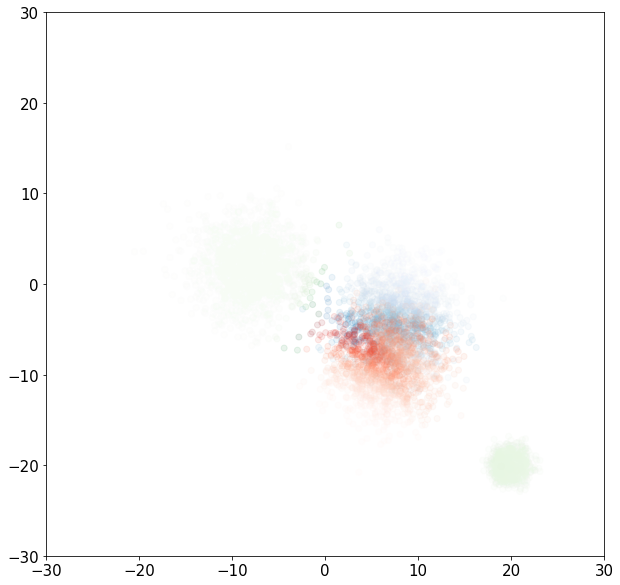

In [26]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,10))
plt.gca().set_xlim([-30.,30.])
plt.gca().set_ylim([-30.,30.])
color = kendalls_entropy[y_test==0]
pa = plt.scatter(X_test[:,0][y_test==0],
         X_test[:,1][y_test==0], 
                 c=color, cmap='Blues', alpha=0.1)
#cba = plt.colorbar(pa)
plt.clim(np.min(kendalls_entropy),np.max(kendalls_entropy))
color = kendalls_entropy[y_test==1]
pb = plt.scatter(X_test[:,0][y_test==1],
         X_test[:,1][y_test==1], 
                 c=color, cmap='Reds', alpha=0.1)
#cbb = plt.colorbar(pb)
plt.clim(np.min(kendalls_entropy),np.max(kendalls_entropy))
color = kendalls_entropy[y_test==2]
pc = plt.scatter(X_test[:,0][y_test==2],
         X_test[:,1][y_test==2], 
                 c=color, cmap='Greens', alpha=0.1)
#cbc = plt.colorbar(pc)
plt.clim(np.min(kendalls_entropy),np.max(kendalls_entropy))
#cba.set_label('zero')
#cbb.set_label('one')
#cbc.set_label('two')

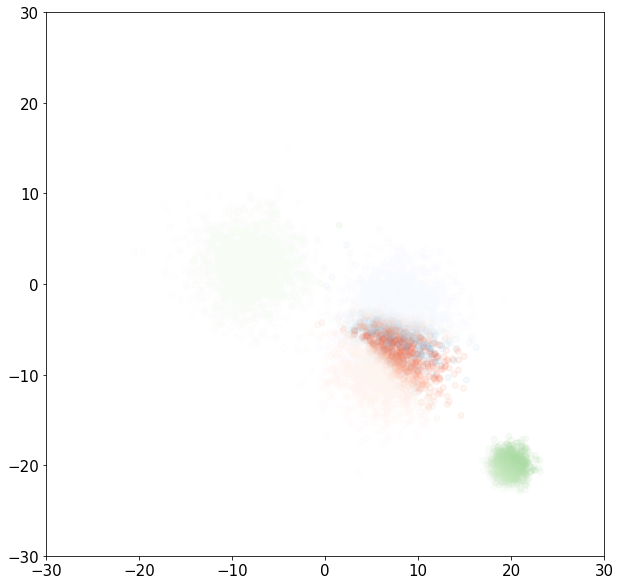

In [27]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,10))
plt.gca().set_xlim([-30.,30.])
plt.gca().set_ylim([-30.,30.])
color = kendalls_var_ratios[y_test==0]
pa = plt.scatter(X_test[:,0][y_test==0],
         X_test[:,1][y_test==0], 
                 c=color, cmap='Blues', alpha=0.1)
#cba = plt.colorbar(pa)
plt.clim(0,1.)
color = kendalls_var_ratios[y_test==1]
pb = plt.scatter(X_test[:,0][y_test==1],
         X_test[:,1][y_test==1], 
                 c=color, cmap='Reds', alpha=0.1)
#cbb = plt.colorbar(pb)
plt.clim(0,1.)
color = kendalls_var_ratios[y_test==2]
pc = plt.scatter(X_test[:,0][y_test==2],
         X_test[:,1][y_test==2], 
                 c=color, cmap='Greens', alpha=0.1)
#cbc = plt.colorbar(pc)
plt.clim(0,1.)
#cba.set_label('zero')
#cbb.set_label('one')
#cbc.set_label('two')


## Uncertainty: Dirichet wrapper

In [28]:
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
import tensorflow as tf
import tensorflow_probability as tfp

class UncertaintyWrapper(object):
  def __init__(self, lambda_reg, num_samples, 
               learning_rate=1e-3, num_hidden_units=20):
    self.lambda_reg = lambda_reg
    self.epsilon = 1e-10
    self.num_samples = num_samples
    self.learning_rate = learning_rate
    self.num_hidden_units = num_hidden_units

  def dirichlet_aleatoric_cross_entropy(self, y_true, y_pred):
    mu_probs = y_pred[:,:self.num_classes]
    logits_sigma = y_pred[:,self.num_classes:]
    beta = logits_sigma + 1e-23
    #beta = tf.broadcast_to(beta,(lambda shape: (shape[0], shape[1]))(tf.shape(mu_probs)))
    alpha = mu_probs * beta
    dirichlet = tfp.distributions.Dirichlet(alpha)
    z = dirichlet.sample(sample_shape=self.num_samples)
    e_probs = tf.reduce_mean(z, axis=0)
    log_probs = tf.math.log(e_probs+self.epsilon)
    cross_entropy = -(tf.reduce_sum(y_true * log_probs, axis=-1))
    return cross_entropy + self.lambda_reg * tf.reduce_sum(tf.square(beta), axis=-1)
  
  # metric that outputs the max/min value for the beta
  def max_beta(self, y_true, y_pred, **args):
    logits_psi = y_pred[:, self.num_classes:]
    return tf.reduce_max(logits_psi)

  def min_beta(self, y_true, y_pred, **args):
    logits_psi = y_pred[:, self.num_classes:]
    return tf.reduce_min(logits_psi)

  # metric that outputs the accuracy when only considering the logits_mu.
  # this accuracy should be the same that was obtained with the fake classifier
  # in its best epoch.
  #def mu_accuracy(self):
  #  num_classes = self.num_classes
  def mu_accuracy(self, y_true, y_pred, **args):
    logits_phi = y_pred[:, :self.num_classes]
    labels_phi = y_true[:, :self.num_classes]
    return categorical_accuracy(labels_phi, logits_phi)
  #  return get_mu_accuracy

  def create_model(self, input_shape):
    model_input = Input(shape=(input_shape,))
    logits_sigma = Dense(self.num_hidden_units, activation='relu')(model_input)
    logits_sigma = Dense(self.num_hidden_units,activation='relu')(logits_sigma)
    logits_sigma = Dense(self.num_hidden_units,activation='relu')(logits_sigma)
    logits_sigma = Dense(self.num_hidden_units,activation='relu')(logits_sigma)
    logits_sigma = Dense(1, activation='softplus')(logits_sigma)
    probs_mu = Input(shape=(self.num_classes,))
    output = concatenate([probs_mu, logits_sigma])

    model = Model(inputs=[model_input, probs_mu], outputs=output)
    model.compile(loss=self.dirichlet_aleatoric_cross_entropy,
                  optimizer=Adam(lr=self.learning_rate),
                  metrics=[self.mu_accuracy, self.min_beta, self.max_beta])
    return model
  
  def train_model(self, X, y, pred_y, batch_size=256, epochs=50):
    self.num_classes = pred_y.shape[1]
    input_shape = X.shape[1]
    self.model = self.create_model(input_shape)
    self.training_history = self.model.fit([X, pred_y],
                             y,
                             batch_size=batch_size,
                             epochs=epochs,
                             shuffle=True,
                             verbose=1,
                             validation_split=0.1)
    
  def predict_entropy(self, X, pred_y):
    y_pred = self.model.predict([X, pred_y])
    logits_mu = y_pred[:,:self.num_classes]
    logits_sigma = y_pred[:,self.num_classes:]
    beta = logits_sigma
    alpha = logits_mu * logits_sigma
    dirichlet = tfp.distributions.Dirichlet(alpha)
    z = dirichlet.sample(sample_shape=self.num_samples)
    e_probs = tf.reduce_mean(z, axis=0)
    log_probs = tf.math.log(e_probs+self.epsilon)
    entropy = tf.reduce_sum(-e_probs*log_probs, axis=-1)
    return entropy

  def voting(self, X, pred_y):
    y_pred = self.model.predict([X, pred_y])
    mu_probs = y_pred[:,:self.num_classes]
    logits_sigma = y_pred[:,self.num_classes:]
    beta = logits_sigma
    alpha = mu_probs * logits_sigma
    dirichlet = tfp.distributions.Dirichlet(alpha)
    z = dirichlet.sample(sample_shape=self.num_samples)
    z = tf.reshape(z, (lambda shape: (self.num_samples, shape[0], shape[1]))(tf.shape(mu_probs)))
    sampled_output = tf.argmax(z, axis=-1, output_type=tf.int32)
    sampled_output = tf.reshape(sampled_output, 
                                (lambda shape: (self.num_samples, -1))(tf.shape(sampled_output)))
    sampled_output = tf.one_hot(sampled_output, axis=-1, depth=self.num_classes)
    sampled_output = tf.reduce_sum(sampled_output, axis=0)
    winner_classes = tf.argmax(sampled_output, axis=1)
    winner_classes = tf.one_hot(winner_classes, axis=-1, depth=self.num_classes)
    sampled_output = tf.reduce_sum(sampled_output * winner_classes, axis=-1)
    return 1-sampled_output/self.num_samples

In [29]:
from time import time
start_time = time()
dirichlet_wrapper = UncertaintyWrapper(1000, 1000, learning_rate=1e-3, num_hidden_units=20)
dirichlet_wrapper.train_model(X_val[:10], to_categorical(y_val[:10], num_classes), fake_y_pred_val[:10],
                             epochs=15, batch_size=256)
"Done in %0.3fs" % (time() - start_time)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9 samples, validate on 1 samples
Epoch 1/15
9/9 [==============================] - 0s 20ms/sample - loss: 988.3896 - mu_accuracy: 1.0000 - min_beta: 0.4285 - max_beta: 1.6247 - val_loss: 67.0716 - val_mu_accuracy: 1.0000 - val_min_beta: 0.2590 - val_max_beta: 0.2590
Epoch 2/15
9/9 [==============================] - 0s 767us/sample - loss: 544.8317 - mu_accuracy: 1.0000 - min_beta: 0.4147 - max_beta: 1.1150 - val_loss: 62.7203 - val_mu_accuracy: 1.0000 - val_min_beta: 0.2504 - val_max_beta: 0.2504
Epoch 3/15
9/9 [==============================] - 0s 981us/sample - loss: 307.1932 - mu_accuracy: 1.0000 - min_beta: 0.3271 - max_beta: 0.7247 - val_loss: 58.9512 - val_mu_accuracy: 1.0000 - val_min_beta: 0.2428 - val_max_beta: 0.2428
Epoch 4/15
9/9 [==============================] - 0s 1ms/sample - loss: 191.3217 - mu_accuracy: 1.0000 - min_beta: 0.2246 - max_beta: 0.5774 - val_loss: 55.3989

'Done in 0.992s'

In [30]:
#pred_beta, pred_alpha, pred_z, pred_e_probs, pred_entropy = K.get_session().run(dirichlet_wrapper.predict(X_test, fake_y_pred_test))
pred_mubeta = dirichlet_wrapper.model.predict([X_test, fake_y_pred_test])
alpha = pred_mubeta[:,num_classes:] * fake_y_pred_test
alpha

array([[4.94227745e-02, 7.38486126e-02, 1.57360236e-10],
       [7.72726387e-02, 8.28232691e-02, 1.16728511e-08],
       [7.13089108e-02, 9.96588320e-02, 2.39748317e-07],
       ...,
       [1.07514752e-05, 5.51124569e-03, 1.76270276e-26],
       [3.10085488e-06, 4.41040611e-03, 2.75796126e-26],
       [6.32311276e-06, 4.90731280e-03, 1.22495146e-26]], dtype=float32)

In [31]:
pred_alpha_samples = K.get_session().run(tfp.distributions.Dirichlet(alpha).sample(sample_shape=1000))
pred_dirichlet_probs = pred_alpha_samples.mean(axis=0)

In [32]:
np.where((y_test == 2) &  (X_test[:,0] > -1) &  (X_test[:,1] < -0.5) &  (X_test[:,1] > -4.5))

(array([3895]),)

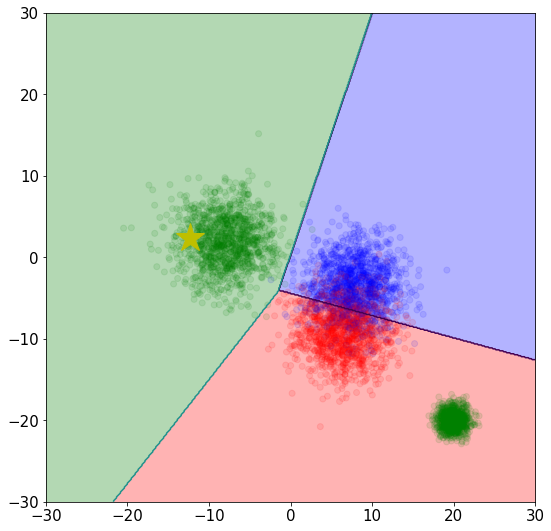

label  2
fake_y_pred_test  [1.6518920e-10 1.8436053e-11 1.0000000e+00]
beta  [0.21857418]
alpha  [3.6106094e-11 4.0296451e-12 2.1857418e-01]
wrapper preds  [7.3202926e-28 7.3202926e-28 1.0000000e+00]
entropy  9.1476915e-26
softmax response  0.0


In [49]:
# point = 136 # np.where((y_test == 2) &  (X_test[:,1] < 2.5) &  (X_test[:,1] > 2))
# point = 2 # np.where((y_test == 0) &  (X_test[:,1] < -5))
# point = 3895 # np.where((y_test == 2) &  (X_test[:,0] > -1) &  (X_test[:,1] < -0.5) &  (X_test[:,1] > -4.5))
# point = 61 # np.where((y_test == 1) &  (X_test[:,1] > -17.5) &  (X_test[:,1] < -15))
# point = 4001 # np.where((y_test == 2) &  (X_test[:,0] > 20) &  (X_test[:,0] < 20.5))
# point = 3520 # np.where((y_test == 1) &  (X_test[:,1] > 0))
# point = 403 # np.where((y_test == 1) &  (X_test[:,0] > 14.5))
point = 136
plot_classifier(fake_model, X_test, y_test, X_test[point])
print('label ', y_test[point])
print('fake_y_pred_test ',fake_y_pred_test[point])
print('beta ', pred_mubeta[:,num_classes:][point])
print('alpha ', alpha[point])
print('wrapper preds ', pred_dirichlet_probs[point])
print('entropy ', -np.sum(np.log(pred_dirichlet_probs[point])*(pred_dirichlet_probs[point]), axis=-1))
print('softmax response ',uncertainty_softmax_response[point])

5.011115e-05
2.0931638e-10


/Users/n955171/miniconda3/envs/uncertanty_modeller_env/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: The following kwargs were not used by contour: 'color'


Text(0.5, 1.0, 'class 2')

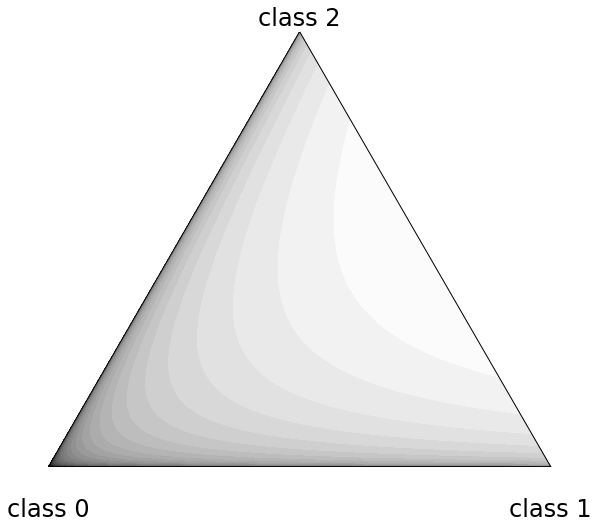

In [34]:
'''Functions for drawing contours of Dirichlet distributions.'''

# Author: Thomas Boggs


tfd = tfp.distributions

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 \
              for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.

    Arguments:

        `xy`: A length-2 sequence containing the x and y value.
    '''
    s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

def draw_pdf_contours(alpha, border=False, nlevels=200, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).

    Arguments:

        `alpha`: parameters for the dirichlet.

        `border` (bool): If True, the simplex border is drawn.

        `nlevels` (int): Number of contours to draw.

        `subdiv` (int): Number of recursive mesh subdivisions to create.

        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    from matplotlib import ticker, cm
    import math

    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    points = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    pvals = K.get_session().run(tfp.distributions.Dirichlet(alpha).prob(points))
    print(np.max(pvals))
    print(np.min(pvals))
    ndiv=30
    pvals = np.power(pvals,0.01)
    lev_list = [np.min(pvals)+1.*i*(np.max(pvals)-np.min(pvals))/ndiv for i in range(ndiv)]
    #plt.tricontourf(trimesh, np.power(pvals,1e-6), nlevels, **kwargs)
    
    plt.tricontourf(trimesh, pvals, levels=lev_list, color=None, **kwargs)
    plt.text(0, -0.1, 'class 0', ha='center')
    plt.text(1, -0.1, 'class 1', ha='center')
    #plt.text(0.5, (0.75**0.5)+0.2, 'class 2', ha='center')
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.triplot(_triangle, linewidth=1, color='black')

def plot_points(X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.

    Arguments:

        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.

        `barycentric` (bool): Indicates if `X` is in barycentric coords.

        `border` (bool): If True, the simplex border is drawn.

        kwargs: Keyword args passed on to `plt.plot`.
    '''
    if barycentric is True:
        X = X.dot(_corners)
    plt.plot(X[:, 0], X[:, 1], **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.triplot(_triangle, linewidth=1)

plt.rcParams.update({'font.size': 24})
f = plt.figure(figsize=(10, 8))
this_alpha = alpha[point]/np.linalg.norm(alpha[point])
dist = K.get_session().run(tfp.distributions.Dirichlet(this_alpha).sample(sample_shape=1000))
from matplotlib import cm
draw_pdf_contours(this_alpha, border=True, subdiv=8, nlevels=40, cmap="gray_r")
title = r'$\alpha$ = (%.5e, %.5e, %.5e)' % tuple(alpha[point].tolist())
plt.title('class 2', fontdict={'fontsize': 24})
#plot_points(dist, alpha=0.05, marker="x", color='black', ms=8, clip_on=False)

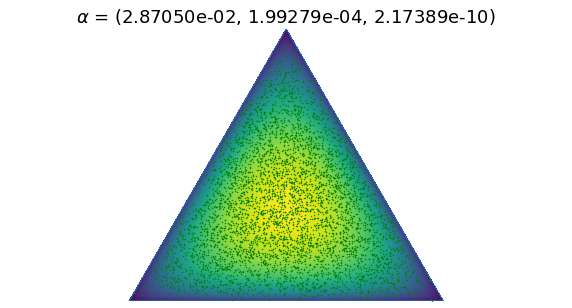

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from functools import reduce

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 \
              for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        `xy`: A length-2 sequence containing the x and y value.
    '''
    s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)

def draw_pdf_contours(dist, border=False, nlevels=200, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).
    Arguments:
        `dist`: A distribution instance with a `pdf` method.
        `border` (bool): If True, the simplex border is drawn.
        `nlevels` (int): Number of contours to draw.
        `subdiv` (int): Number of recursive mesh subdivisions to create.
        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    from matplotlib import ticker, cm
    import math

    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        plt.hold(1)
        plt.triplot(_triangle, linewidth=1)

def plot_points(X, barycentric=True, border=True, **kwargs):
    '''Plots a set of points in the simplex.
    Arguments:
        `X` (ndarray): A 2xN array (if in Cartesian coords) or 3xN array
                       (if in barycentric coords) of points to plot.
        `barycentric` (bool): Indicates if `X` is in barycentric coords.
        `border` (bool): If True, the simplex border is drawn.
        kwargs: Keyword args passed on to `plt.plot`.
    '''
    if barycentric is True:
        X = X.dot(_corners)
    plt.plot(X[:, 0], X[:, 1], 'k.', ms=1, **kwargs, c='g')
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    if border is True:
        #plt.hold(1)
        plt.triplot(_triangle, linewidth=1)

f = plt.figure(figsize=(10, 5))
this_alpha = [1.5, 1.5, 1.5]
dist = Dirichlet(this_alpha)
draw_pdf_contours(dist, nlevels=100)
title = r'$\alpha$ = (%.5e, %.5e, %.5e)' % tuple(alpha[point])
plt.title(title, fontdict={'fontsize': 18})
plot_points(dist.sample(5000))

In [38]:
dirichlet_pred_entropy = K.get_session().run(dirichlet_wrapper.predict_entropy(X_test, fake_y_pred_test))
dirichlet_var_ratios = K.get_session().run(dirichlet_wrapper.voting(X_test, fake_y_pred_test))

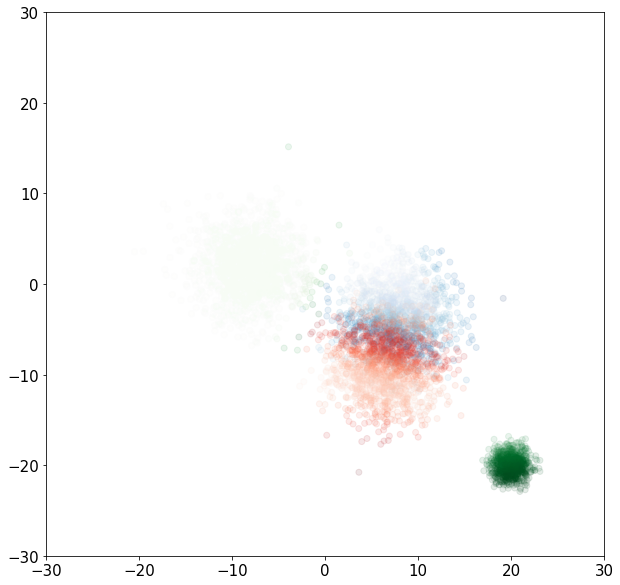

In [39]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,10))
plt.gca().set_xlim([-30.,30.])
plt.gca().set_ylim([-30.,30.])
color = dirichlet_pred_entropy[y_test==0]
pa = plt.scatter(X_test[:,0][y_test==0],
         X_test[:,1][y_test==0], 
                 c=color, cmap='Blues', alpha=0.1)
#cba = plt.colorbar(pa)
plt.clim(np.min(dirichlet_pred_entropy),np.max(dirichlet_pred_entropy))
color = dirichlet_pred_entropy[y_test==1]
pb = plt.scatter(X_test[:,0][y_test==1],
         X_test[:,1][y_test==1], 
                 c=color, cmap='Reds', alpha=0.1)
#cbb = plt.colorbar(pb)
plt.clim(np.min(dirichlet_pred_entropy),np.max(dirichlet_pred_entropy))
color = dirichlet_pred_entropy[y_test==2]
pc = plt.scatter(X_test[:,0][y_test==2],
         X_test[:,1][y_test==2], 
                 c=color, cmap='Greens', alpha=0.1)
#cbc = plt.colorbar(pc)
plt.clim(np.min(dirichlet_pred_entropy),np.max(dirichlet_pred_entropy))
#cba.set_label('zero')
#cbb.set_label('one')
#cbc.set_label('two')

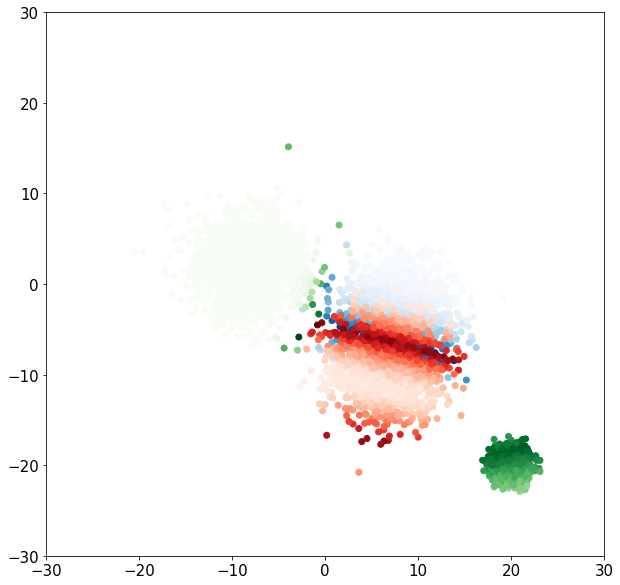

In [40]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,10))
plt.gca().set_xlim([-30.,30.])
plt.gca().set_ylim([-30.,30.])
color = dirichlet_var_ratios[y_test==0]
pa = plt.scatter(X_test[:,0][y_test==0],
         X_test[:,1][y_test==0], 
                 c=color, cmap='Blues')
#cba = plt.colorbar(pa)
#plt.clim(0,1.)
color = dirichlet_var_ratios[y_test==1]
pb = plt.scatter(X_test[:,0][y_test==1],
         X_test[:,1][y_test==1], 
                 c=color, cmap='Reds')
#cbb = plt.colorbar(pb)
#plt.clim(0,1.)
color = dirichlet_var_ratios[y_test==2]
pb = plt.scatter(X_test[:,0][y_test==2],
         X_test[:,1][y_test==2], 
                 c=color, cmap='Greens')
#cbc = plt.colorbar(pc)
#plt.clim(0,1.)
#cba.set_label('zero')
#cbb.set_label('one')
#cbc.set_label('two')

Text(0.5, 1.0, 'd) Dirichlet predictive entropy')

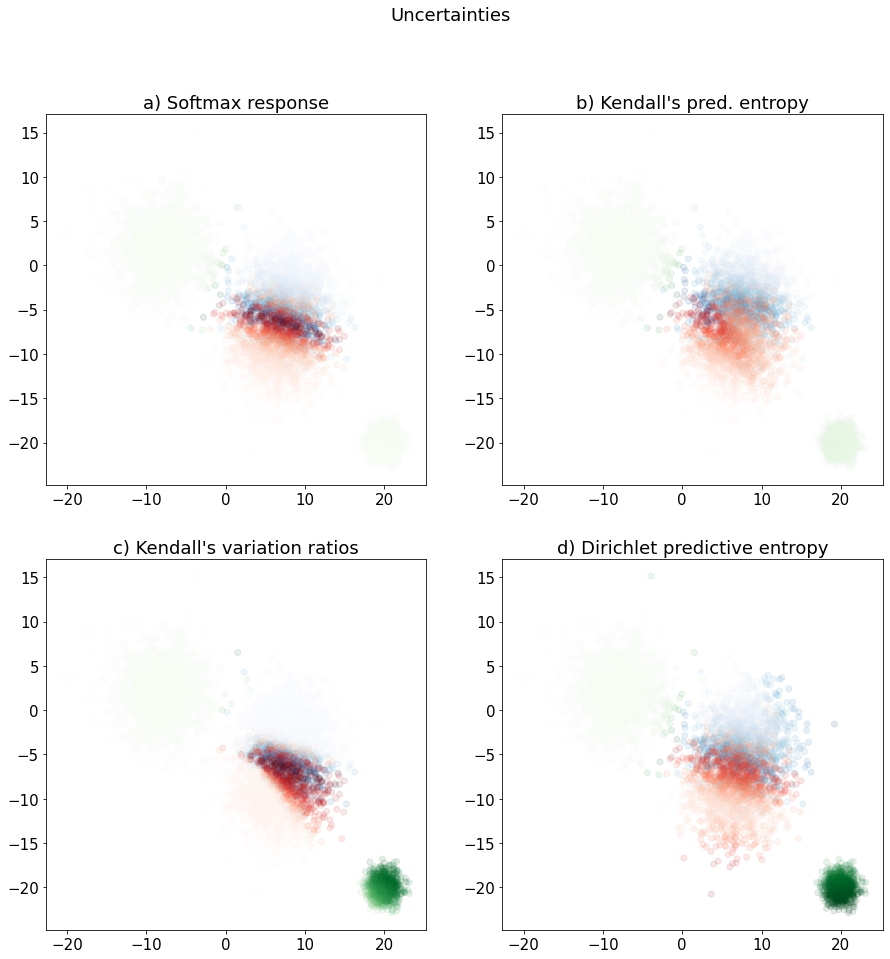

In [41]:
fig, axs = plt.subplots(2,2,figsize=(15,15))
fig.suptitle('Uncertainties')
color = uncertainty_softmax_response[y_test==0]
axs[0,0].scatter(X_test[:,0][y_test==0],
         X_test[:,1][y_test==0], 
                 c=color, cmap='Blues', alpha=0.1)
color = uncertainty_softmax_response[y_test==1]
axs[0,0].scatter(X_test[:,0][y_test==1],
         X_test[:,1][y_test==1], 
                 c=color, cmap='Reds', alpha=0.1)
color = uncertainty_softmax_response[y_test==2]
axs[0,0].scatter(X_test[:,0][y_test==2],
         X_test[:,1][y_test==2], 
                 c=color, cmap='Greens', alpha=0.1)
axs[0,0].set_title('a) Softmax response')
color = kendalls_entropy[y_test==0]
axs[0,1].scatter(X_test[:,0][y_test==0],
         X_test[:,1][y_test==0], 
                 c=color, cmap='Blues', alpha=0.1)
color = kendalls_entropy[y_test==1]
axs[0,1].scatter(X_test[:,0][y_test==1],
         X_test[:,1][y_test==1], 
                 c=color, cmap='Reds', alpha=0.1)
color = kendalls_entropy[y_test==2]
axs[0,1].scatter(X_test[:,0][y_test==2],
         X_test[:,1][y_test==2], 
                 c=color, cmap='Greens', alpha=0.1)
axs[0,1].set_title('b) Kendall\'s pred. entropy')
color = kendalls_var_ratios[y_test==0]
axs[1,0].scatter(X_test[:,0][y_test==0],
         X_test[:,1][y_test==0], 
                 c=color, cmap='Blues', alpha=0.1)
color = kendalls_var_ratios[y_test==1]
axs[1,0].scatter(X_test[:,0][y_test==1],
         X_test[:,1][y_test==1], 
                 c=color, cmap='Reds', alpha=0.1)
color = kendalls_var_ratios[y_test==2]
axs[1,0].scatter(X_test[:,0][y_test==2],
         X_test[:,1][y_test==2], 
                 c=color, cmap='Greens', alpha=0.1)
axs[1,0].set_title('c) Kendall\'s variation ratios')
color = dirichlet_pred_entropy[y_test==0]
axs[1,1].scatter(X_test[:,0][y_test==0],
         X_test[:,1][y_test==0], 
                 c=color, cmap='Blues', alpha=0.1)
color = dirichlet_pred_entropy[y_test==1]
axs[1,1].scatter(X_test[:,0][y_test==1],
         X_test[:,1][y_test==1], 
                 c=color, cmap='Reds', alpha=0.1)
color = dirichlet_pred_entropy[y_test==2]
axs[1,1].scatter(X_test[:,0][y_test==2],
         X_test[:,1][y_test==2], 
                 c=color, cmap='Greens', alpha=0.1)
axs[1,1].set_title('d) Dirichlet predictive entropy')

In [42]:
def get_rejection_measures(prediction, true_label, rejection_heuristic, rejection_point):
    assert len(prediction) == len(true_label) == len(rejection_heuristic)
    num_total_points = len(prediction) # n
    num_non_rejected_points = rejection_point # N
    num_rejected_points = num_total_points - rejection_point # R
    rejection_percentage = (num_rejected_points / num_total_points) * 100
    accurately_classified = (np.sum(prediction[rejection_heuristic] == 
                                    true_label[rejection_heuristic])) # a
    
    accurately_classified_non_rejected = (np.sum(prediction[rejection_heuristic][:rejection_point] 
                                            == true_label[rejection_heuristic][:rejection_point])) # a_N 
    accurately_classified_rejected = (np.sum(prediction[rejection_heuristic][rejection_point:] 
                                        == true_label[rejection_heuristic][rejection_point:])) # a_R
    non_rejected_accuracy = accurately_classified_non_rejected / num_non_rejected_points # A = ||a_N|| / ||N||
    classification_quality = ((accurately_classified_non_rejected + (num_rejected_points-accurately_classified_rejected)) /
                                num_total_points) # Q = ||a_N||+||1-a_R|| / n
    rejection_quality = (((num_rejected_points-accurately_classified_rejected)/accurately_classified_rejected) 
                        / ((num_total_points-accurately_classified)/accurately_classified)) # phi = ||1-a_R||/||a_r / ||1-a||/||a||
    return non_rejected_accuracy, classification_quality, rejection_quality, rejection_percentage

In [43]:
test_y_pred = np.argmax(fake_y_pred_test, axis=1)
rejection_measures_softmax_response = np.array([list(get_rejection_measures(test_y_pred, y_test, np.argsort(uncertainty_softmax_response), rejection_point))
                                              for rejection_point in range(1,len(test_y_pred))])
rejection_measures_kendalls_entropy = np.array([list(get_rejection_measures(test_y_pred, y_test, np.argsort(kendalls_entropy), rejection_point))
                                              for rejection_point in range(1,len(test_y_pred))])
rejection_measures_kendalls_var_ratios = np.array([list(get_rejection_measures(test_y_pred, y_test, np.argsort(kendalls_var_ratios), rejection_point))
                                              for rejection_point in range(1,len(test_y_pred))])
rejection_measures_dirichlet_pred_entropy = np.array([list(get_rejection_measures(test_y_pred, y_test, np.argsort(dirichlet_pred_entropy), rejection_point))
                                              for rejection_point in range(1,len(test_y_pred))])
rejection_measures_dirichlet_var_ratios = np.array([list(get_rejection_measures(test_y_pred, y_test, np.argsort(dirichlet_var_ratios), rejection_point))
                                              for rejection_point in range(1,len(test_y_pred))])

/Users/n955171/miniconda3/envs/uncertanty_modeller_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in long_scalars


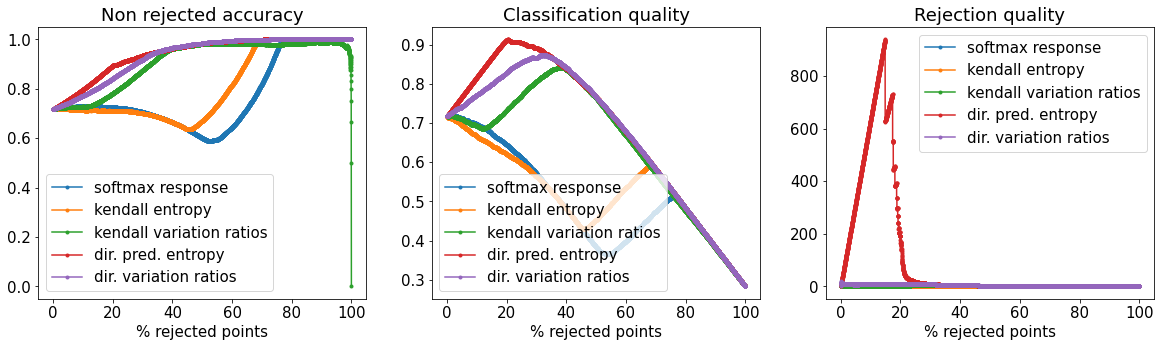

In [44]:
metrics = ['Non rejected accuracy', 'Classification quality', 'Rejection quality']
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20,5))

for i in range(0, 3):
    plt.subplot(1,3,i+1)
    plt.plot(rejection_measures_softmax_response[:,3], rejection_measures_softmax_response[:,i], label='softmax response', marker="o", markersize=3)
    plt.plot(rejection_measures_kendalls_entropy[:,3], rejection_measures_kendalls_entropy[:,i], label='kendall entropy', marker="o", markersize=3)
    plt.plot(rejection_measures_kendalls_var_ratios[:,3], rejection_measures_kendalls_var_ratios[:,i], label='kendall variation ratios', marker="o", markersize=3)
    plt.plot(rejection_measures_dirichlet_pred_entropy[:,3], rejection_measures_dirichlet_pred_entropy[:,i], label='dir. pred. entropy', marker="o", markersize=3)
    plt.plot(rejection_measures_dirichlet_var_ratios[:,3], rejection_measures_dirichlet_var_ratios[:,i], label='dir. variation ratios', marker="o", markersize=3)
    plt.xlabel('% rejected points')
    plt.title(metrics[i])
    plt.xscale('linear')
    plt.ylim()
    plt.legend()